## Multifunctional Chatbot for an Auto Dealership with LLMs

**Car-ing is sharing**, an auto dealership company for car sales and rental, is taking their services to the next level thanks to **Large Language Models (LLMs)**.

As their newly recruited AI and NLP developer, you've been asked to prototype a chatbot app with multiple functionalities that not only assist customers but also provide support to human agents in the company.

The solution should receive textual prompts and use a variety of pre-trained Hugging Face LLMs to respond to a series of tasks, e.g. classifying the sentiment in a car’s text review, answering a customer question, summarizing or translating text, etc.

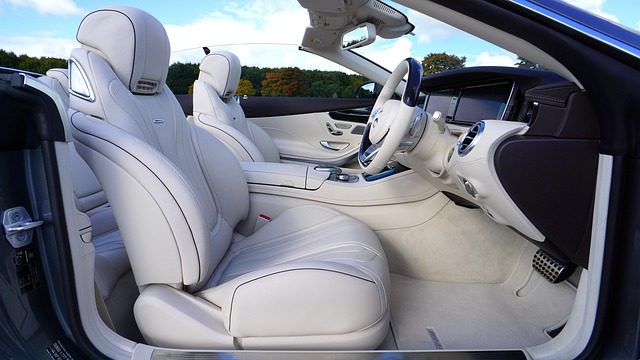

In [ ]:
!pip install transformers
!pip install evaluate

from transformers import logging
logging.set_verbosity(logging.WARNING)

In [2]:
# Start your code here!
import pandas as pd
import torch

# Load the car reviews dataset
file_path = "car_reviews.csv"
df = pd.read_csv(file_path, delimiter=";")

# Put the car reviews and their associated sentiment labels in two lists
reviews = df['Review'].tolist()
real_labels = df['Class'].tolist()

### Sentiment Analysis

In [3]:
# Load a sentiment analysis LLM into a pipeline
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Perform inference on the car reviews and display prediction results
predicted_labels = classifier(reviews)
for review, prediction, label in zip(reviews, predicted_labels, real_labels):
    print(f"Review: {review}\nActual Sentiment: {label}\nPredicted Sentiment: {prediction['label']} (Confidence: {prediction['score']:.4f})\n")

# Load accuracy and F1 score metrics
import evaluate
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Map categorical sentiment labels into integer labels
references = [1 if label == "POSITIVE" else 0 for label in real_labels]
predictions = [1 if label['label'] == "POSITIVE" else 0 for label in predicted_labels]

# Calculate accuracy and F1 score
accuracy_result_dict = accuracy.compute(references=references, predictions=predictions)
accuracy_result = accuracy_result_dict['accuracy']
f1_result_dict = f1.compute(references=references, predictions=predictions)
f1_result = f1_result_dict['f1']
print(f"Accuracy: {accuracy_result}")
print(f"F1 result: {f1_result}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Review: I am very satisfied with my 2014 Nissan NV SL. I use this van for my business deliveries and personal use. Camping, road trips, etc. We dont have any children so I store most of the seats in my warehouse. I wanted the passenger van for the rear air conditioning. We drove our van from Florida to California for a Cross Country trip in 2014. We averaged about 18 mpg. We drove thru a lot of rain and It was a very comfortable and stable vehicle. The V8 Nissan Titan engine is a 500k mile engine. It has been tested many times by delivery and trucking companies. This is why Nissan gives you a 5 year or 100k mile bumper to bumper warranty. Many people are scared about driving this van because of its size. But with front and rear sonar sensors, large mirrors and the back up camera. It is easy to drive. The front and rear sensors also monitor the front and rear sides of the bumpers making it easier to park close to objects. Our Nissan NV is a Tow Monster. It pulls our 5000 pound travel tr

Accuracy: 0.8
F1 result: 0.8571428571428571


- We can see, for the five examples of reviews, with their actual sentiment and the model's predicted sentiment.
The model performs well with an accuracy of 0.8 and F1 score of 0.857.

- The review about the 2014 Nissan NV SL is positive for both human and model prediction.
- The review about a car with repeated transmission failure is marked as negative by the human but positive by the model (potential misclassification).
- The last review highlights some blind spot issues but an overall positive experience, which is correctly captured by the model.

## Translation

In [8]:
#reviews[0]

In [9]:
# Load translation LLM into a pipeline and translate car review
first_review = reviews[0]
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fi")
translated_review = translator(first_review, max_length=27)[0]['translation_text']
print(f"Model translation:\n{translated_review}")

# Load reference translations from file
with open("translations.txt", 'r') as file:
    lines = file.readlines()
references = [line.strip() for line in lines]
print(f"Finnish translation references:\n{references}")

# Load and calculate BLEU score metric
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=[translated_review], references=[references])
print(bleu_score['bleu'])

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Your input_length: 377 is bigger than 0.9 * max_length: 27. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


Model translation:
Olen erittäin tyytyväinen vuoden 2014 Nissan NV SL:hen. Käytän tätä pakettiautoa liiketoimintaani ja henkilökohtaiseen
Finnish translation references:
['Olen erittäin tyytyväinen vuoden 2014 Nissan NV SL:ääni. Käytän tätä kuorma-autoa kaupallisiin toimituksiin ja henkilökohtaiseen käyttöön.', 'Olen erittäin tyytyväinen vuoden 2014 Nissan NV SL:ääni. Käytän tätä pakettiautoa kaupallisiin toimituksiini ja henkilökohtaiseen käyttöön.']
0.5595205105615875


**Why is the belu score low ? **
- Data-driven: The translation model is trained on a specific dataset. If the dataset doesn't contain enough examples of similar English sentences and their corresponding Finnish translations, the model might struggle to generate accurate translations.
- Complexity of the English text: The original English review is quite long and detailed, with a variety of topics and nuances. This can make it challenging for the model to capture all the subtleties and produce a perfect translation.
- BLEU Score's Limitations: Focus on n-gram matches: BLEU primarily measures the overlap of n-grams (sequences of words) between the translated text and the reference translations. This can lead to limitations, especially when dealing with paraphrasing or semantic equivalence.
Sensitivity to minor errors: BLEU can be sensitive to minor errors or differences in word order, even if the overall meaning is conveyed accurately.

## Extractive QA
Extractive QA is a technique used to answer questions by directly extracting relevant information from a given text. It involves identifying and highlighting specific spans of text that contain the answer.



In [10]:
# Import auto classes (optional: can be solved via pipelines too)
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering

# Instantiate model and tokenizer
model_ckp = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckp)
model = AutoModelForQuestionAnswering.from_pretrained(model_ckp)

# Define context and question, and tokenize them
context = reviews[1]
print(f"Context:\n{context}")
question = "What did he like about the brand?"
inputs = tokenizer(question, context, return_tensors="pt")

# Perform inference and extract answer from raw outputs
with torch.no_grad():
  outputs = model(**inputs)
start_idx = torch.argmax(outputs.start_logits)
end_idx = torch.argmax(outputs.end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]

# Decode and show answer
answer = tokenizer.decode(answer_span)
print("Answer: ", answer)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Context:
The car is fine. It's a bit loud and not very powerful. On one hand, compared to its peers, the interior is well-built. The transmission failed a few years ago, and the dealer replaced it under warranty with no issues. Now, about 60k miles later, the transmission is failing again. It sounds like a truck, and the issues are well-documented. The dealer tells me it is normal, refusing to do anything to resolve the issue. After owning the car for 4 years, there are many other vehicles I would purchase over this one. Initially, I really liked what the brand is about: ride quality, reliability, etc. But I will not purchase another one. Despite these concerns, I must say, the level of comfort in the car has always been satisfactory, but not worth the rest of issues found.
Answer:  ride quality, reliability


Extractive QA could have many applications within a business. For example, a model would likely be used to answer questions about the car review, such as "What is the car's most significant problem?" or "What does the reviewer like about the car's interior?"

## Summarization

In [11]:
# Get original text to summarize upon car review
text_to_summarize = reviews[-1]
print(f"Original text:\n{text_to_summarize}")

# Load summarization pipeline and perform inference
model_name = "cnicu/t5-small-booksum"
summarizer = pipeline("summarization", model=model_name)
outputs = summarizer(text_to_summarize, max_length=53)
summarized_text = outputs[0]['summary_text']
print(f"Summarized text:\n{summarized_text}")

Original text:
I've been dreaming of owning an SUV for quite a while, but I've been driving cars that were already paid for during an extended period. I ultimately made the decision to transition to a brand-new car, which, of course, involved taking on new payments. However, given that I don't drive extensively, I was inclined to avoid a substantial financial commitment. The Nissan Rogue provides me with the desired SUV experience without burdening me with an exorbitant payment; the financial arrangement is quite reasonable. Handling and styling are great; I have hauled 12 bags of mulch in the back with the seats down and could have held more. I am VERY satisfied overall. I find myself needing to exercise extra caution when making lane changes, particularly owing to the blind spots resulting from the small side windows situated towards the rear of the vehicle. To address this concern, I am actively engaged in making adjustments to my mirrors and consciously reducing the frequency of la

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Summarized text:
the Nissan Rogue provides me with the desired SUV experience without burdening me with an exorbitant payment; the financial arrangement is quite reasonable. I have hauled 12 bags of mulch in the back with the seats down and could have held more.


Summarization can have many applications within business operations. For example make summary of meeting...